## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(str(PATH), sz)

In [6]:
m = wrn_22()

In [7]:
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.5
learn.clip = 1e-1

In [9]:
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                   
    0      0.118189   0.642997   0.8363    
    1      0.18062    0.421725   0.8688                    
    2      0.218938   1.684123   0.6506                    
    3      0.242908   0.902181   0.7517                    
    4      0.252289   0.68185    0.7982                    
    5      0.251165   0.553371   0.827                     
    6      0.259474   0.955814   0.755                     
    7      0.254422   1.025792   0.7199                    
    8      0.251834   0.466718   0.8493                    
    9      0.239405   0.423445   0.8619                    
    10     0.22983    0.506543   0.8323                    
    11     0.215466   0.595569   0.8163                    
    12     0.206588   0.685819   0.8095                    
    13     0.19571    0.612388   0.8236                    
    14     0.174963   0.459937   0.8597                    
    15     0.145889   0.397332   0.8797                

[array([0.1997]), 0.9430000015258789]

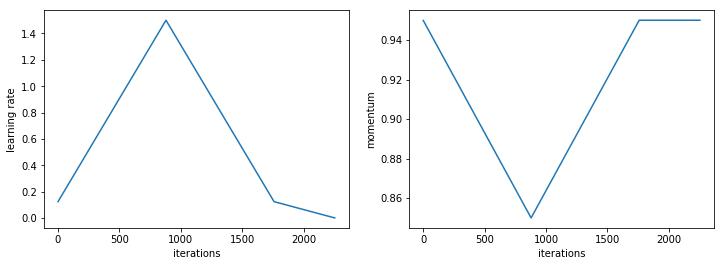

In [10]:
learn.sched.plot_lr()